In [1]:
"""
@File    : playground.ipynb
@Create  : 2024/12/03 15:42:02
@Modify  : 2024/12/03 15:42:02
@Author  : Flora Sun
@Contact : floras@animocabrands.com
@Desc    : None
"""

'\n@File    : playground.ipynb\n@Create  : 2024/12/03 15:42:02\n@Modify  : 2024/12/03 15:42:02\n@Author  : Flora Sun\n@Contact : floras@animocabrands.com\n@Desc    : None\n'

# Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import sybil_functions
import trino_fetch
import importlib
from datetime import datetime
from tqdm import tqdm
import requests
from time import sleep
import matplotlib.pyplot as plt
import random
from collections import Counter
import plotly.graph_objects as go
import re


importlib.reload(sybil_functions)
importlib.reload(trino_fetch)

from sybil_functions import (
    read_from_multiple_csv,
    check_df,
    count_pairs,
    remove_contract_transactions,
    stretched_sigmoid,
    get_weight_df,
    plot_weight_dist,
    plot_weight_cumulative_dist,
    create_community,
    community_visualization,
    file_name_lst,
    random_rate,
    find_main_wallet,
    find_transfer_for_wallet,
    find_commu_for_wallet,
    uncommon_wallets,
    filter_community_lst,
    expand_community_lst,
    calculate_likelihoods,
    check_contract,
)
from trino_fetch import query_trino

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}


In [3]:
os.getcwd()

'/Users/floras/Desktop/unique-user/-Model'

In [4]:
# set the path to the focal repository
os.chdir("/Users/floras/Desktop/unique-user")

# Import data

## Contract data

In [63]:
known_contract = read_from_multiple_csv(
    "contract-data",
    file_name_lst("contract-data", startswith="contract", endswith="moca_airdrop.csv"),
)
print(known_contract.shape)
known_contract.head()

(91, 4)


,address,contract/public account,sus,note
0,0x76dd65529dc6c073c1e0af2a5ecc78434bdbf7d9,y,NaN,NaN
1,0xe50ddf54c958a63ec1f2ab4fd48c899de7bfaa0b,NaN,y,"high-frequency in on polygon, mainly from 0x29..."
2,0x9008d19f58aabd9ed0d60971565aa8510560ab41,y,NaN,NaN
3,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,y,NaN,moca staking
4,0xdc066677b5ee2c577132b69ac13da6cf8a50c1c7,y,NaN,NaN


## Moca Airdrop Receiver Info

In [64]:
moca_airdrop_df = pd.read_excel("moca-airdrop/data/moca_airdrop_user_info.xlsx")
moca_airdrop_df.head()

KeyboardInterrupt: 

In [ ]:
moca_airdrop_df["address"].nunique()

29164

### Addresses with more than 1 Moca ID

In [ ]:
addresses_with_more_than_one = moca_airdrop_df["address"].value_counts()
addresses_with_more_than_one = addresses_with_more_than_one[
    addresses_with_more_than_one > 1
]
addresses_with_more_than_one = addresses_with_more_than_one.index.tolist()

print(addresses_with_more_than_one)

['0x7646c2e54f972ea0def55b66b4f05416acd49db0', '0x916b0395e409bdcda99294fb5094d3492c0933cd', '0xfd1b9568fcdaee267c98f45070f27e17a82ffe43', '0x030e8df34cb8eca071b813472b4ac7822f39896d', '0x1611009da0dd85f772ef8fcff5de1a5cfdff8f97', '0x53078efd332cf24bc158804b7ac92e0cf6171327', '0x34e667710c5f5fbf366023fa1664bfc71e4bb2ae', '0x88720be48c436b763eb3978198a5261a856c9725', '0x65f8f6fc92d58aa586da5b678c994e1413d9e939']


### Wallet list and wallet set

In [ ]:
wallet_lst = moca_airdrop_df["address"]
wallet_lst = wallet_lst.str.lower()
wallet_lst = [x for x in wallet_lst if x not in set(addresses_with_more_than_one)]

wallet_set = set(wallet_lst)
wallet_lst = list(wallet_set)
print(len(wallet_lst))

29156


## Native token transfer data

In [ ]:
native_trans_path = "moca-airdrop/data/raw-data"

In [ ]:
native_trans_file_lst = file_name_lst(
    native_trans_path, startswith="native", endswith=".csv"
)
native_trans_df_0 = read_from_multiple_csv(native_trans_path, native_trans_file_lst)
native_trans_df_0 = native_trans_df_0[
    native_trans_df_0["from_address"].isin(wallet_set)
    | native_trans_df_0["to_address"].isin(wallet_set)
]
native_trans_df_0 = native_trans_df_0[
    (native_trans_df_0["from_address"].isna() == False)
    & (native_trans_df_0["to_address"].isna() == False)
]
native_trans_df_0.columns = [
    "timestamp",
    "from_address",
    "to_address",
    "native_tx_count",
]
print(native_trans_df_0.shape)
native_trans_df_0.head()

(180673, 4)


,timestamp,from_address,to_address,native_tx_count
0,2024-06-01 00:00:00.000 UTC,0xbb14ed78c9fc563e5263bc3502fa86aec887194b,0xca3840c43962aa4857f9237463825071cb7da071,10
1,2024-06-01 00:00:00.000 UTC,0xf36f26f3d31f58772c99321fafed6729c3f47f5e,0xa137e8b1ff0339328572bad9c788c23586eaa63c,28
2,2024-06-01 00:00:00.000 UTC,0xda1bbc89a1deeed513363654324a0ebb17946ee0,0x6c5e87309ee7ff13628cc8c8dbb5fbbb4cb7ca5c,29
3,2024-06-01 00:00:00.000 UTC,0xf0cbace7452b530aa18ff0870e3475ec71ba362b,0x95a7f9cd4db3564146599267f7848fe20ad5c59e,1
4,2024-06-01 00:00:00.000 UTC,0xf327d13cd7bc9b3ea7485a97dfbbd0cc998635b8,0x6b1e3ddecc11583ed189b1db217873aa1c65a72e,1


# ❗️Remove Contract 

In [ ]:
known_contract

,address,contract/public account,sus,note
0,0x76dd65529dc6c073c1e0af2a5ecc78434bdbf7d9,y,NaN,NaN
1,0xe50ddf54c958a63ec1f2ab4fd48c899de7bfaa0b,NaN,y,"high-frequency in on polygon, mainly from 0x29..."
2,0x9008d19f58aabd9ed0d60971565aa8510560ab41,y,NaN,NaN
3,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,y,NaN,moca staking
4,0xdc066677b5ee2c577132b69ac13da6cf8a50c1c7,y,NaN,NaN
...,...,...,...,...
86,0x3b5a23f6207d87b423c6789d2625ea620423b32d,y,NaN,NaN
87,0x0ec68c5b10f21effb74f2a5c61dfe6b08c0db6cb,y,NaN,NaN
88,0xdd3cb5c974601bc3974d908ea4a86020f9999e0c,y,NaN,NaN
89,0xa333a24652a305cf082e861c2b1bd0b77186f5bb,NaN,y,high frequency transaction


In [ ]:
def get_interacted_w(unique_pairs_df, w_cols=["wallet_a", "wallet_b"]):
    wallet_z = list()
    for col in w_cols:
        wallet_z += list(unique_pairs_df[col])
    wallet_z_count = Counter(wallet_z)
    wallet_z_count = pd.DataFrame(
        wallet_z_count.items(), columns=["wallet", "interacted_wallets"]
    )
    return wallet_z_count

In [ ]:
def get_wallet_raw_interaction_count(
    raw_transaction_df, address_cols=["from_address", "to_address"]
):
    raw_transaction_df["pair"] = raw_transaction_df.apply(
        lambda x: tuple(sorted([x[address_cols[0]], x[address_cols[1]]])), axis=1
    )
    unique_pairs = pd.DataFrame(raw_transaction_df["pair"].unique())
    unique_pairs.columns = ["pair"]
    unique_pairs["wallet_a"] = unique_pairs["pair"].apply(lambda x: x[0])
    unique_pairs["wallet_b"] = unique_pairs["pair"].apply(lambda x: x[1])
    wallet_count = get_interacted_w(unique_pairs, w_cols=["wallet_a", "wallet_b"])
    return wallet_count

In [ ]:
contract_check_df = get_wallet_raw_interaction_count(native_trans_df_0)
contract_check_df.head()

,wallet,interacted_wallets
0,0xbb14ed78c9fc563e5263bc3502fa86aec887194b,1
1,0xa137e8b1ff0339328572bad9c788c23586eaa63c,7
2,0x6c5e87309ee7ff13628cc8c8dbb5fbbb4cb7ca5c,4
3,0x95a7f9cd4db3564146599267f7848fe20ad5c59e,5
4,0x6b1e3ddecc11583ed189b1db217873aa1c65a72e,1


In [ ]:
def check_wallet(w, trace_back_days_=30):
    result = {
        "wallet": w,
        "is_contract": None,
    }

    # step 1: check if it is a contract
    result["is_contract"] = check_contract(w)
    # if result["is_contract"]:
    #     trace_back_days_ = -1

    # # step 2: check other metrics
    # result["trace_back_days"] = trace_back_days_
    # trace_result, _ = query_trino(w, trace_back_days_)
    # result.update(trace_result)

    return result

In [ ]:
contract_check_df_test = contract_check_df.copy()
contract_check_df_test = contract_check_df_test.iloc[:1000]

In [ ]:
contract_check_df_test["if_contract"] = contract_check_df_test.apply(
    lambda x: (
        check_wallet(x["wallet"])["is_contract"]
        if x["interacted_wallets"] > 100
        else None
    ),
    axis=1,
)

contract_check_df_test

0x4c968f6beecf1906710b08e8b472b8ba6e75f957 is not a contract
0x76dd65529dc6c073c1e0af2a5ecc78434bdbf7d9 is not a contract
0x64301a9b71acbfadc72e4f3405069b74494c57b1 is not a contract
0x1651d700cd4020334bd185ba4c6e0271ffc0c732 is not a contract
0x7fac5c5b7e6d24614d7db1489486142d680abbc8 is not a contract
0x4c5fdee62c192630ff67f39f42f56c55fd670069 is not a contract
0x684f7c4b755681a47a7cf62e720ba7341c5fb2b5 is not a contract
0x76f6988610b1c294d8b0de3e725005af9d557b00 is not a contract
0xaa364c1a348f9517009207a1601e0a73c1cd530b is not a contract
0xbf5e3c7afbe37d13b040adb11d497bdbe061c87b is not a contract
0xae5fa7a833b658035c6746b49616fbed4203f3a4 is not a contract


,wallet,interacted_wallets,if_contract
0,0xbb14ed78c9fc563e5263bc3502fa86aec887194b,1,None
1,0xa137e8b1ff0339328572bad9c788c23586eaa63c,7,None
2,0x6c5e87309ee7ff13628cc8c8dbb5fbbb4cb7ca5c,4,None
3,0x95a7f9cd4db3564146599267f7848fe20ad5c59e,5,None
4,0x6b1e3ddecc11583ed189b1db217873aa1c65a72e,1,None
...,...,...,...
995,0x8367d1e63fba145bea04cb5675314654f1a4fafe,30,None
996,0x9cf6e18aea1b4209b49cce9ff11aa503fef34bc3,26,None
997,0x35b0828eaa9d57761b73fcd8705e350ba7bdf58f,2,None
998,0x019d0706d65c4768ec8081ed7ce41f59eef9b86c,16,None


In [ ]:
contract_check_df_test[contract_check_df_test["if_contract"] == False]

,wallet,interacted_wallets,if_contract
67,0x4c968f6beecf1906710b08e8b472b8ba6e75f957,209,False
119,0x76dd65529dc6c073c1e0af2a5ecc78434bdbf7d9,782,False
139,0x64301a9b71acbfadc72e4f3405069b74494c57b1,147,False
232,0x1651d700cd4020334bd185ba4c6e0271ffc0c732,237,False
281,0x7fac5c5b7e6d24614d7db1489486142d680abbc8,147,False
330,0x4c5fdee62c192630ff67f39f42f56c55fd670069,226,False
515,0x684f7c4b755681a47a7cf62e720ba7341c5fb2b5,157,False
546,0x76f6988610b1c294d8b0de3e725005af9d557b00,125,False
600,0xaa364c1a348f9517009207a1601e0a73c1cd530b,131,False
676,0xbf5e3c7afbe37d13b040adb11d497bdbe061c87b,101,False


In [ ]:
check_contract('0xe7804c37c13166fF0b37F5aE0BB07A3aEbb6e245')

0xe7804c37c13166fF0b37F5aE0BB07A3aEbb6e245 is not a contract


False

In [ ]:
query_trino("0xa333a24652a305cf082e861c2b1bd0b77186f5bb")  # contract

({'unique_wallets': 31110,
  'unique_transactions': 31115,
  'mean_interval': Timedelta('0 days 00:03:14.296072507'),
  'max_interval': Timedelta('69 days 12:25:32'),
  'median_interval': Timedelta('0 days 00:00:00'),
  'one_fourth_interval': Timedelta('0 days 00:00:00')},
                                         transaction_hash  \
 30859  0xef84093c9321760ac47ac6d12cbe6f0d35b76a27a2a9...   
 0      0x48f25b0c9110dc2074dceb12567998ddd27a05557a82...   
 11439  0xaf3bc75c3f56a2b2c21cc9b27be64f20800d7dfeac7b...   
 12348  0x8b74b42abfadecbbd4aafdf4cb58d36119a2fb30d73d...   
 27384  0xfe6cbf65cf7cf6a609d0e56ddd1432aa9f095a9ba790...   
 ...                                                  ...   
 28348  0x06ee786af7203660f55aa1aca85ff2a0312357f33913...   
 11710  0xdd23eaa13301f6cd7c10319d6de2e4137578f892451a...   
 31001  0xda569dfd37aae273c14214ad8b06f1374f6d2c57d431...   
 2044   0x83e90e548e7899436ab435019964cb781000baba43e1...   
 1      0xfd0f44998c8223acb554bc1de2aa9a74989104cb211b.

31115

31110

# Transaction count -> Weight

In [ ]:
# set sigmoid parameters
stretch = 1

In [ ]:
weight_df = trans_df_count.copy()

# Revise the if_wallet_a and if_wallet_b columns
weight_df["if_wallet_a"] = weight_df["wallet_a"].isin(wallet_set)
weight_df["if_wallet_b"] = weight_df["wallet_b"].isin(wallet_set)

# Calculate the internal weight
weight_df["moca_weight"] = weight_df.apply(
    lambda x: (stretched_sigmoid(x["moca_tx_count"], stretch) - 0.5) * 5, axis=1
)

# Calculate the total weight
weight_df["native_weight"] = weight_df.apply(
    lambda x: stretched_sigmoid(x["native_tx_count"], stretch) - 0.5,
    axis=1,
)

weight_df["weight"] = weight_df["moca_weight"] + weight_df["native_weight"]

# Sort based on weight
weight_df = weight_df.sort_values(by="weight", ascending=False)

In [ ]:
check_df(weight_df)

(114737, 10)

pair                object
native_tx_count    float64
moca_tx_count      float64
wallet_a            object
wallet_b            object
if_wallet_a           bool
if_wallet_b           bool
moca_weight        float64
native_weight      float64
weight             float64
dtype: object

,native_tx_count,moca_tx_count,moca_weight,native_weight,weight
count,114737.000000,114737.000000,114737.000000,114737.000000,114737.000000
mean,2.274890,0.079033,0.081420,0.284523,0.365943
std,7.363418,0.397767,0.316284,0.122147,0.268935
min,0.000000,0.000000,0.000000,0.000000,0.231059
25%,1.000000,0.000000,0.000000,0.231059,0.231059
50%,1.000000,0.000000,0.000000,0.231059,0.231059
75%,2.000000,0.000000,0.000000,0.380797,0.380797
max,539.000000,29.000000,2.500000,0.500000,2.986726


,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
37778,"(0x2e6ef714225ae97647305fe6e3d23adebf95161f, 0...",7.0,6.0,0x2e6ef714225ae97647305fe6e3d23adebf95161f,0xb5d19f46aeb528b8d698fca297d38a3e55461513,True,False,2.487637,0.499089,2.986726
5031,"(0x04898c077eb5f6e3dc5f6086cd96ceeed523cd81, 0...",4.0,6.0,0x04898c077eb5f6e3dc5f6086cd96ceeed523cd81,0x0e209f2bf981399b1cf7cd4054e2a78efc56ba55,True,False,2.487637,0.482014,2.969651
93813,"(0x9283b44a6e4b5c12ad3ed2a56dff38d4496e2506, 0...",13.0,5.0,0x9283b44a6e4b5c12ad3ed2a56dff38d4496e2506,0x9985d0fd7bc0fc7b16cc68ad6f30ec8e1d02af86,True,False,2.466536,0.499998,2.966533
28359,"(0x211cea4e6e15457f2e92c611714e7b11b0738055, 0...",5.0,5.0,0x211cea4e6e15457f2e92c611714e7b11b0738055,0xea5f4f4440ff3cc417d09b43d6f8da1f14175846,True,True,2.466536,0.493307,2.959843
106025,"(0xb8b17ccd40cb726cff486c6cfc23bcf1111fe685, 0...",3.0,6.0,0xb8b17ccd40cb726cff486c6cfc23bcf1111fe685,0xc7f2886d1ac8e743a3a45aaefffeea3ca21dff21,False,True,2.487637,0.452574,2.940211


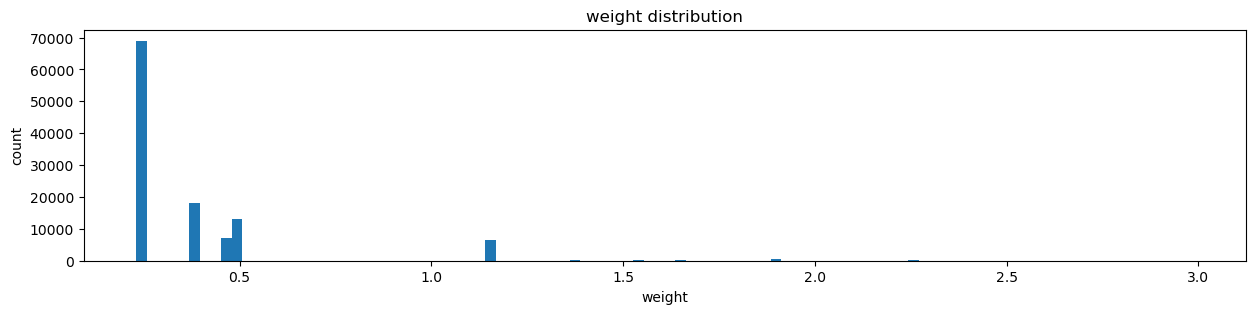

In [ ]:
plot_weight_dist(weight_df)

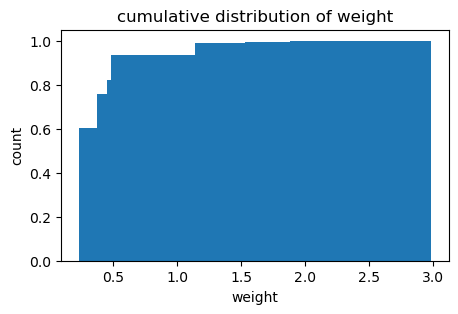

In [ ]:
plot_weight_cumulative_dist(weight_df)

# Weight -> Community

In [ ]:
resolution_value = 225

In [ ]:
print(f"resultion: {resolution_value}")
community_lst_lou, G_lou = create_community(
    weight_df, "louvain", resolution=resolution_value
)

# community_lst_s = create_community(weight_df, 'surprise')
# community_lst_lei = create_community(weight_df, 'leiden')

resultion: 225
Method: louvain
Number of unique wallets: 90759
Number of edges: 114737
Number of communities detected: 10856
-
Average community size: 8.360261606484894
Max community size: 598
Min community size: 1



In [ ]:
# get the wallet likelihood of louvain
wallet_likelihood_lou = calculate_likelihoods(community_lst_lou, G_lou)

In [ ]:
# get the wallet likelihood df
wallet_likelihood_df = pd.DataFrame(wallet_likelihood_lou).T.reset_index(drop=False)
wallet_likelihood_df["if_airdrop"] = wallet_likelihood_df["index"].isin(wallet_set)
wallet_likelihood_df["if_white"] = wallet_likelihood_df["index"].isin(white_set)

In [ ]:
# row_lst = range(10)
row_lst = [14]
community_lst_visualization_1 = community_lst_lou

# get the wallet info of the current community
wallet_info_df_1 = wallet_likelihood_df[wallet_likelihood_df["community"] == row_lst[0]]

for row in row_lst:
    community = community_lst_visualization_1[row]
    print("Size of community:", len(community))
    # print(find_main_wallet(community, weight_df))

    commu_visual_df_1 = weight_df.loc[
        weight_df["wallet_a"].isin(community) & weight_df["wallet_b"].isin(community)
    ]

    print("Average weight:", commu_visual_df_1["weight"].mean())

Size of community: 140
Average weight: 1.1552928931500246


In [ ]:
community_visualization(commu_visual_df_1)

In [ ]:
commu_visual_df_1

,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
98683,"(0x9d2e830ca205b3a8422c96005a4b37948f8da793, 0...",0.0,1.0,0x9d2e830ca205b3a8422c96005a4b37948f8da793,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
90677,"(0x8a1fd37aad280c568e66ad4d84fcbf93415bdff0, 0...",0.0,1.0,0x8a1fd37aad280c568e66ad4d84fcbf93415bdff0,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
112245,"(0xdd29fc8bcf1f3fe45107fd1077a95d3e728eb198, 0...",0.0,1.0,0xdd29fc8bcf1f3fe45107fd1077a95d3e728eb198,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
101439,"(0xa678fc52c08089dfd85d7792a576d3bce6a0c521, 0...",0.0,1.0,0xa678fc52c08089dfd85d7792a576d3bce6a0c521,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
114100,"(0xf048005481237ad9a814dc464d82814286383fbc, 0...",0.0,1.0,0xf048005481237ad9a814dc464d82814286383fbc,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
...,...,...,...,...,...,...,...,...,...,...
42813,"(0x364459c27cfa5b2453e889d68a65c99b8b04c1f1, 0...",0.0,1.0,0x364459c27cfa5b2453e889d68a65c99b8b04c1f1,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
44207,"(0x382f164c30bea00e8cd6c55c20de514c0a8fcb56, 0...",0.0,1.0,0x382f164c30bea00e8cd6c55c20de514c0a8fcb56,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
14353,"(0x0ed200c94b68b886b62150591cc8536f707fd0e1, 0...",0.0,1.0,0x0ed200c94b68b886b62150591cc8536f707fd0e1,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293
24436,"(0x1af4a919a7f3e135c0f4b531371861712b65dbea, 0...",0.0,1.0,0x1af4a919a7f3e135c0f4b531371861712b65dbea,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,True,True,1.155293,0.0,1.155293


In [ ]:
test = pd.DataFrame(find_main_wallet(community, commu_visual_df_1)).reset_index(
    drop=False
)
test["if_airdrop"] = test["index"].isin(wallet_set)
test["if_contract"] = test["index"].isin(known_contract["address"])
test["if_white"] = test["index"].isin(white_set)
# test[-test[['if_airdrop', 'if_contract', 'if_white']].any(axis=1)].head(15)
test.head(30)

,index,0,if_airdrop,if_contract,if_white
0,0xfe50c40732188c33770ce4ba8f2c45a9d994e88e,139.0,True,False,False
1,0x00aa009ac584f9974c50d51e76a38955d78cd17a,1.0,True,False,False
2,0xad0df3bd01d481b8a5b0f5189dba769744039e61,1.0,True,False,False
3,0x9d15751f38e605f51f65cfd00dd741d3f6f3124b,1.0,True,False,False
4,0x9d2e830ca205b3a8422c96005a4b37948f8da793,1.0,True,False,False
5,0x9de6b1ef056453c7378ab69b07fc678190b236f4,1.0,True,False,False
6,0xa678fc52c08089dfd85d7792a576d3bce6a0c521,1.0,True,False,False
7,0xa82394f836a058093df1c5259283ca3b2fe0bf2d,1.0,True,False,False
8,0xacf6eb0f252c00d5e8f58f97fd216b276c2d6e39,1.0,True,False,False
9,0xad753159b742074c0da0d0a1b958dfe41411b6cd,1.0,True,False,False


In [ ]:
wallet_info_df_1 = wallet_info_df_1.sort_values(by="edge_density", ascending=False)
wallet_info_df_1 = wallet_info_df_1.reset_index(drop=True)

# wallet_info_df_1[-wallet_info_df_1[['if_white' , "if_airdrop"]].any(axis = 1)]
wallet_info_df_1

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x5253cbed3c528dca0a0a22f644ae501dca045e9d,5000.0,1.0,0.000029,1.000000,True,False
1,0x7127ff35dd53e33f3ef6a7948794678cec2f17db,5000.0,1.0,0.000012,0.333333,False,False
2,0x640ed3b766122892ad7d839a24c1a7ea1f568344,5000.0,1.0,0.000011,0.333333,False,False
3,0xe040fd7466fdae5414a293b1edfd38bad5c22b67,5000.0,1.0,0.000006,0.333333,False,False


### wallet_likelihood_df normalization

In [ ]:
wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,0.0,0.986777,4.086449e-03,0.986777,True,False
1,0xd8c4437d8c893ba9cad7cc612141fd209c9ee24c,0.0,1.000000,1.073425e-05,0.001675,False,False
2,0x180f02accd56d4662366bdc7f4d5edd0f367ce40,0.0,1.000000,9.031823e-06,0.001675,False,False
3,0x181746415239bd772f59de7d76657e54139b3c59,0.0,1.000000,9.031823e-06,0.001675,False,False
4,0x130129dd0cc3298090d716c6302a7776be7b7578,0.0,1.000000,9.031823e-06,0.001675,False,False
...,...,...,...,...,...,...,...
90754,0x99d6c23e5cc5e2ab01aec8962ed5c3bdab2f9c58,10851.0,0.000000,-1.514189e-11,0.000000,False,False
90755,0x993ae7516f2c6b08ae9991047c84ef8863262d0a,10852.0,0.000000,-1.514189e-11,0.000000,False,False
90756,0x96bfc698bd8a7e6636bf1a2ce1373800c1457132,10853.0,0.000000,-1.514189e-11,0.000000,False,False
90757,0x97fe5acfd8b66ffd0a518b4855cc333b97ba137e,10854.0,0.000000,-1.514189e-11,0.000000,False,False


In [ ]:
# Function to generate new normalized columns within each community
def generate_normalized_cols(group):
    group["normalized_modularity_contribution"] = (
        group["modularity_contribution"] / group["modularity_contribution"].max()
    )
    group["normalized_jaccard_similarity"] = (
        group["jaccard_similarity"] / group["jaccard_similarity"].max()
    )
    return group


# Apply normalization and generate new columns
wallet_likelihood_df = (
    wallet_likelihood_df.groupby("community")
    .apply(generate_normalized_cols)
    .reset_index(drop=True)
)

In [ ]:
display(wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,0.0,0.986777,4.086449e-03,0.986777,True,False,1.000000,1.000000
1,0xd8c4437d8c893ba9cad7cc612141fd209c9ee24c,0.0,1.000000,1.073425e-05,0.001675,False,False,0.002627,0.001697
2,0x180f02accd56d4662366bdc7f4d5edd0f367ce40,0.0,1.000000,9.031823e-06,0.001675,False,False,0.002210,0.001697
3,0x181746415239bd772f59de7d76657e54139b3c59,0.0,1.000000,9.031823e-06,0.001675,False,False,0.002210,0.001697
4,0x130129dd0cc3298090d716c6302a7776be7b7578,0.0,1.000000,9.031823e-06,0.001675,False,False,0.002210,0.001697
...,...,...,...,...,...,...,...,...,...
90754,0x99d6c23e5cc5e2ab01aec8962ed5c3bdab2f9c58,10851.0,0.000000,-1.514189e-11,0.000000,False,False,1.000000,NaN
90755,0x993ae7516f2c6b08ae9991047c84ef8863262d0a,10852.0,0.000000,-1.514189e-11,0.000000,False,False,1.000000,NaN
90756,0x96bfc698bd8a7e6636bf1a2ce1373800c1457132,10853.0,0.000000,-1.514189e-11,0.000000,False,False,1.000000,NaN
90757,0x97fe5acfd8b66ffd0a518b4855cc333b97ba137e,10854.0,0.000000,-1.514189e-11,0.000000,False,False,1.000000,NaN


In [ ]:
wallet_likelihood_df["community"].value_counts()

0.0        598
1.0        504
2.0        501
3.0        455
4.0        308
          ... 
9353.0       1
9352.0       1
9351.0       1
9350.0       1
10855.0      1
Name: community, Length: 10856, dtype: int64

# Refine community

In [ ]:
edge_density_threshold = 0.5

In [ ]:
# keep only those with edge_density > 0.5 in community
wallet_likelihood_df = wallet_likelihood_df[
    wallet_likelihood_df["edge_density"] > edge_density_threshold
]
display(wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,0.0,0.986777,0.004086,0.986777,True,False,1.000000,1.000000
1,0xd8c4437d8c893ba9cad7cc612141fd209c9ee24c,0.0,1.000000,0.000011,0.001675,False,False,0.002627,0.001697
2,0x180f02accd56d4662366bdc7f4d5edd0f367ce40,0.0,1.000000,0.000009,0.001675,False,False,0.002210,0.001697
3,0x181746415239bd772f59de7d76657e54139b3c59,0.0,1.000000,0.000009,0.001675,False,False,0.002210,0.001697
4,0x130129dd0cc3298090d716c6302a7776be7b7578,0.0,1.000000,0.000009,0.001675,False,False,0.002210,0.001697
...,...,...,...,...,...,...,...,...,...
90295,0x60b67a260a3c1264c79b8705dce5da06885e742d,10392.0,1.000000,0.000006,0.000000,True,False,1.000000,NaN
90350,0xacc2056a66c65d6f98eee6430d2010f25b46e10c,10447.0,1.000000,0.000006,0.000000,True,False,1.000000,NaN
90382,0x696d2f64d91b698b84d4943f163b771aa43b9921,10479.0,1.000000,0.000006,0.000000,True,False,1.000000,NaN
90450,0x1824955b3ba2b926f942fd276c0f5e087d437e56,10547.0,1.000000,0.000006,0.000000,True,False,1.000000,NaN


# Merge back to the original moca airdrop df

In [ ]:
# keep only airdrop wallets
airdrop_wallet_likelihood_df = wallet_likelihood_df[
    wallet_likelihood_df["if_airdrop"] == True
]
# reset index
airdrop_wallet_likelihood_df = airdrop_wallet_likelihood_df.reset_index(drop=True)
display(airdrop_wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,0.0,0.986777,0.004086,0.986777,True,False,1.00000,1.000000
1,0x55daff1234a6f81e982238bafad9b2fb79f185c6,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
2,0x1efd0876eace43d493c662c74258b4e56c0019d9,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
3,0xe43de0ea86519bd6e2c8ed797706340437e267c6,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
4,0xe9fb4c3693c2c9fac9cd09f92c4ea2454f4c209f,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
...,...,...,...,...,...,...,...,...,...
16128,0x60b67a260a3c1264c79b8705dce5da06885e742d,10392.0,1.000000,0.000006,0.000000,True,False,1.00000,NaN
16129,0xacc2056a66c65d6f98eee6430d2010f25b46e10c,10447.0,1.000000,0.000006,0.000000,True,False,1.00000,NaN
16130,0x696d2f64d91b698b84d4943f163b771aa43b9921,10479.0,1.000000,0.000006,0.000000,True,False,1.00000,NaN
16131,0x1824955b3ba2b926f942fd276c0f5e087d437e56,10547.0,1.000000,0.000006,0.000000,True,False,1.00000,NaN


In [ ]:
# remove communities with no more than certain number of wallets
community_size_threshold = 2

In [ ]:
## Count occurrences of each community
community_counts = airdrop_wallet_likelihood_df["community"].value_counts()
## Filter to keep only communities with more than one occurrence
filtered_airdrop_wallet_likelihood_df = airdrop_wallet_likelihood_df[
    airdrop_wallet_likelihood_df["community"].isin(
        community_counts[community_counts > community_size_threshold].index
    )
]
# reset index
filtered_airdrop_wallet_likelihood_df.reset_index(drop=True, inplace=True)

In [ ]:
filtered_airdrop_wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,0.0,0.986777,0.004086,0.986777,True,False,1.00000,1.000000
1,0x55daff1234a6f81e982238bafad9b2fb79f185c6,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
2,0x1efd0876eace43d493c662c74258b4e56c0019d9,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
3,0xe43de0ea86519bd6e2c8ed797706340437e267c6,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
4,0xe9fb4c3693c2c9fac9cd09f92c4ea2454f4c209f,0.0,1.000000,0.000009,0.001675,True,False,0.00221,0.001697
...,...,...,...,...,...,...,...,...,...
8685,0xc58d1d95e8e5709cfeca104c16881f186236e94d,6235.0,1.000000,0.000011,1.000000,True,False,1.00000,1.000000
8686,0xb007ff1c6f2e7c7ee3d952dbb69f958242755e3c,6235.0,1.000000,0.000006,0.500000,True,False,0.50000,0.500000
8687,0x24a2cac05b7409fbd4261c8df17a1f59b77572f7,6402.0,1.000000,0.000006,0.500000,True,False,0.50000,0.500000
8688,0x7fb78286e2b2f01156a2af04e03d9a8ffa453bc5,6402.0,1.000000,0.000011,1.000000,True,False,1.00000,1.000000


In [ ]:
pd.DataFrame(filtered_airdrop_wallet_likelihood_df["community"].value_counts()).iloc[
    :30
]

,community
14.0,139
18.0,90
44.0,72
43.0,64
61.0,63
30.0,63
52.0,61
11.0,59
86.0,55
45.0,51


In [ ]:
# change community number into continuous number
community_mapping = {
    old: new
    for new, old in enumerate(
        sorted(filtered_airdrop_wallet_likelihood_df["community"].unique())
    )
}
filtered_airdrop_wallet_likelihood_df["community"] = (
    filtered_airdrop_wallet_likelihood_df["community"].map(community_mapping)
)
display(filtered_airdrop_wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,0,0.684298,0.003583,0.684298,True,False
1,0x26d2b48f9bd52fce421849c90973fc1e7451e007,0,1.000000,0.000011,0.002415,True,False
2,0x7cf9259df2d98919de457d9bb303dc312bced05a,0,1.000000,0.000011,0.002415,True,False
3,0xe9fb4c3693c2c9fac9cd09f92c4ea2454f4c209f,0,1.000000,0.000011,0.002415,True,False
4,0xe43de0ea86519bd6e2c8ed797706340437e267c6,0,1.000000,0.000011,0.002415,True,False
...,...,...,...,...,...,...,...
8690,0x704988427a04cf1e8ed688da66160d8e024d2828,1113,1.000000,0.000007,0.500000,True,False
8691,0xad8f94796f214098b8b19fadc6cb8c97d0baabd6,1113,1.000000,0.000007,0.500000,True,False
8692,0x3a9cfb39262d18909d439a35054e994fd3cbd297,1114,1.000000,0.000007,0.500000,True,False
8693,0xc58d1d95e8e5709cfeca104c16881f186236e94d,1114,1.000000,0.000014,1.000000,True,False


## merge back

In [ ]:
final_moca_airdrop_df = moca_airdrop_df.copy()
final_moca_airdrop_df = final_moca_airdrop_df.merge(
    filtered_airdrop_wallet_likelihood_df[
        [
            "index",
            "community",
            "edge_density",
            # "modularity_contribution",
            # "jaccard_similarity",
            # 'normalized_modularity_contribution',
            # 'normalized_jaccard_similarity'
        ]
    ],
    left_on="address",
    right_on="index",
    how="left",
)
final_moca_airdrop_df = final_moca_airdrop_df.drop(columns=["index"])
final_moca_airdrop_df = final_moca_airdrop_df.rename(
    columns={"community": "community_id"}
)
final_moca_airdrop_df

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,community_id,edge_density
0,NaN,0016e1a3-0cdf-475b-b921-2d121453bece,0016e1a3-0cdf-475b-b921-2d121453bece,kppytiuynykiboo,7418689.0,kppytiuynykiboo,0x4b5591379a65c0180103f421cce640c679d1d9d8,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,590112.0,2d45d118-3d6f-4c7f-930d-5c9f3d56f612,7418689.0,NaN,NaN
1,semidmitrii@gmail.com,00284435-f796-45ad-8c61-5cf4a5417043,00284435-f796-45ad-8c61-5cf4a5417043,therock,25939.0,therock,0x3f1f1694941ebea878fe9e88b048dcb6f0c8f07b,0x5335b140366404b2bd875339322de16f9cd9651c,0xe23308c15434f903825112035cc1d26914fab078,60816.0,6ee964db-f14c-49ad-84db-84d937463cb3,25939.0,NaN,NaN
2,NaN,0048b42e-7630-42a2-9633-9ee78c35f2eb,0048b42e-7630-42a2-9633-9ee78c35f2eb,mocae,7361874.0,mocae,0x38c24c4158033ef3967f102748cba1d56079bd31,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,43567.0,5cbe41a2-b90c-43cb-9560-af5cb0cb2b2f,7361874.0,583.0,0.666667
3,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,294969.0,182f98d8-9098-4763-be3d-4e47985beb8f,8000019.0,NaN,NaN
4,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xd1f01c4bc479967f4dbde0a73f961dd14afa524f,343872.0,abe31f57-dcd4-4bec-a434-414e2c0d2181,8000019.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,morganlooppop123@gmail.com,ffbb185f-902c-4a8d-b1b7-091c812f9252,ffbb185f-902c-4a8d-b1b7-091c812f9252,travinh,7343296.0,travinh,0x07ba7510639dba58e85c4cc912049eb7cb5cbabd,0x1d0827244a15e1c408e75275476c847b0da3c8cc,0xca13b9e8cc74311809c7e6fad638fa2d83d46738,33060.0,b1fefeda-f6fa-479a-be69-809d6d8d0994,7343296.0,17.0,1.000000
29518,NaN,ffc59ccd-522f-4f94-8d55-e9175496b810,ffc59ccd-522f-4f94-8d55-e9175496b810,morphiii,7400295.0,morphiii,0x96a99e32a447cf1315894d459f75721037e9f349,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,61355.0,5aede406-1e89-4163-b48b-2e8653dc7752,7400295.0,NaN,NaN
29519,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x7c5410619d98b5ee0b32a8c5e6913e8ce79d3781,366822.0,30adbad5-bbf3-47a4-81d3-4dd24926f05b,7158743.0,NaN,NaN
29520,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x0273113b6955ea23f17b6af53394f59df26197b1,73435.0,ee1d8d4c-3060-49f9-976a-4547e86de90c,7158743.0,NaN,NaN


In [ ]:
final_moca_airdrop_df[final_moca_airdrop_df["community_id"] == 0]

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,community_id,edge_density,modularity_contribution,jaccard_similarity,normalized_modularity_contribution,normalized_jaccard_similarity
4087,NaN,5672fdcf-8469-4321-b7e8-ea60e19eb3b5,5672fdcf-8469-4321-b7e8-ea60e19eb3b5,garung9907,7364086.0,garung9907,0x3bddb14f3444d0bc81ee0f87acbf99ba9f4a237f,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0x82f704da6d4ea62d9f2d169895e329101a4048f4,151020.0,f2e746db-af68-4e07-b4f2-fa48309963fc,7364086.0,0.0,0.991525,0.005387,0.995745,1.000000,1.00000
12117,NaN,f0bddadf-236a-49c1-a6c8-434c1cb42607,f0bddadf-236a-49c1-a6c8-434c1cb42607,xichuacachua,7690922.0,xichuacachua,0xbc66e7c749ae80f707990de5fbaf41a3a972b1d2,0x81d4689e7a7227137237bb046af5bf9bd88548f7,0x81d4689e7a7227137237bb046af5bf9bd88548f7,154808.0,2c0cb46f-302a-4b7f-b623-2055a42097d2,7690922.0,0.0,1.000000,0.000047,0.004292,0.008761,0.00431
23962,NaN,08710cb6-f33a-4573-ba98-d49befd28d13,08710cb6-f33a-4573-ba98-d49befd28d13,killsama,7691090.0,killsama,0x844186379ab92b19b43c766fa38deace8a0fbf79,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,158132.0,3329f860-7ef4-43e7-9efe-0c126c3274a5,7691090.0,0.0,1.000000,0.000060,0.008584,0.011122,0.00862


# Export result

In [ ]:
final_moca_airdrop_df.to_excel(
    f"moca-airdrop/result/moca_airdrop_r225_1031.xlsx", index=False
)

# Appendix: Check

In [ ]:
filtered_airdrop_wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0x81d4689e7a7227137237bb046af5bf9bd88548f7,0,1.000000,0.000047,0.004292,True,False,0.008761,0.004310
1,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0,0.991525,0.005387,0.995745,True,False,1.000000,1.000000
2,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,0,1.000000,0.000060,0.008584,True,False,0.011122,0.008620
3,0x2f7a721c59e23d27cf93abb1f3c018b8c3de91e2,1,0.984252,0.002886,0.984252,True,False,1.000000,1.000000
4,0x0c96a4c2cec463e7fe45f7b10bf543c16778829f,1,1.000000,0.000067,0.016000,True,False,0.023230,0.016256
...,...,...,...,...,...,...,...,...,...
8260,0x3f69af4b19eccc4e155e40fa0bcd31f8b11a480c,896,1.000000,0.000023,0.500000,True,False,0.500000,0.500000
8261,0xe9363fa0d82f16f6b78cd3219ee7edc3d4706df3,896,1.000000,0.000023,0.500000,True,False,0.500000,0.500000
8262,0x08387241bf9c311f82b6bd3d46d9858f51c2cd71,897,1.000000,0.000023,0.500000,True,False,0.500000,0.500000
8263,0xea7757625337045a8387eaf4fcba34bf1f1aad2a,897,1.000000,0.000045,1.000000,True,False,1.000000,1.000000


## check one community

In [ ]:
# check one community
community_index = 0
community_wallets = filtered_airdrop_wallet_likelihood_df[
    filtered_airdrop_wallet_likelihood_df["community"] == community_index
]["index"]
community_wallets = list(community_wallets)

In [ ]:
# check one community transfers
check_community_df = weight_df[
    weight_df["wallet_a"].isin(community_wallets)
    & weight_df["wallet_b"].isin(community_wallets)
]
display(check_community_df)

,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
24272,"(0x81d4689e7a7227137237bb046af5bf9bd88548f7, 0...",4.0,0.0,0x81d4689e7a7227137237bb046af5bf9bd88548f7,0x82f704da6d4ea62d9f2d169895e329101a4048f4,True,True,0.0,0.482014,0.482014
24449,"(0x82de52df36d3ae50875ab90ab30031f9f2d7f871, 0...",2.0,0.0,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,0x82f704da6d4ea62d9f2d169895e329101a4048f4,True,True,0.0,0.380797,0.380797
24465,"(0x82f704da6d4ea62d9f2d169895e329101a4048f4, 0...",1.0,0.0,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0x82f704da6d4ea62d9f2d169895e329101a4048f4,True,True,0.0,0.231059,0.231059


## visualize the community

In [ ]:
# visualize the community
# community_visualization(check_community_df)

## community size

In [ ]:
# community size
filtered_airdrop_wallet_likelihood_df["community"].value_counts().sort_values(
    ascending=False
)

4      64
5      60
3      57
12     51
18     49
       ..
798     3
829     3
853     3
852     3
897     3
Name: community, Length: 898, dtype: int64

## likelihood of airdrop wallets

In [ ]:
# likelihood of airdrop wallets
filtered_airdrop_wallet_likelihood_df["edge_density"].value_counts().sort_index(
    ascending=False
)

1.000000    7052
0.991525       1
0.984848       1
0.984252       1
0.983051       1
0.977273       1
0.952381       1
0.950000       1
0.944444       1
0.937500       4
0.935484       1
0.931034       1
0.929577       1
0.928571       5
0.925926       1
0.923077       3
0.916667       5
0.909091       6
0.902439       1
0.900000      10
0.894737       1
0.888889      19
0.882353       1
0.875000      21
0.869565       1
0.866667       1
0.857143      46
0.846154       1
0.833333      79
0.823529       1
0.818182       2
0.807692       1
0.800000     137
0.785714       1
0.777778      10
0.769231       4
0.761905       1
0.757576       1
0.750000     197
0.736842       2
0.727273       1
0.714286      22
0.700000       6
0.666667     514
0.642857       1
0.636364       1
0.625000      16
0.612903       2
0.600000      58
0.588235       1
0.583333       1
0.571429      12
0.566038       1
0.555556       1
0.545455       1
0.523810       1
0.512195       1
Name: edge_density, dtype: int6

# Section 2: Tune Hyperparameters

## Parameter 1: send_to_received_min threshold
We keep only external wallets whose send_to_received ratio is above _**[HP - 1]**_

The higher the [HP - 1], the smaller the sample -> theoretically, the harder to form a community

In [ ]:
from_count = pd.Series(native_trans_df_0["from_address"].value_counts())
to_count = pd.Series(native_trans_df_0["to_address"].value_counts())
# Combine the two Series into a DataFrame
other_wallet_transfer_counts = pd.DataFrame(
    {"sent_count": from_count, "received_count": to_count}
)
# Fill NaN values with 0
other_wallet_transfer_counts = other_wallet_transfer_counts.fillna(0)
# Remove airdrop wallets
other_wallet_transfer_counts = other_wallet_transfer_counts[
    ~other_wallet_transfer_counts.index.isin(wallet_set)
]
# Calculate the send-to-received ratio
other_wallet_transfer_counts["send_to_received"] = other_wallet_transfer_counts[
    "sent_count"
] / (
    other_wallet_transfer_counts["received_count"]
    + other_wallet_transfer_counts["sent_count"]
)

other_wallet_transfer_counts

,sent_count,received_count,send_to_received
0x00000000000ebccded8ad28e591c96ac3337be59,0.0,3.0,0.000000
0x0000000000d310f8802cc91f198d14bc2303230b,1.0,17.0,0.055556
0x00000000b74fd0aaca0696c878a037bf86712159,1.0,0.0,1.000000
0x00000002f32c0886ee65d68059fbdb76ef6a6996,13.0,11.0,0.541667
0x0000000313176233f21a11979de3c7369ee2d89a,0.0,1.0,0.000000
...,...,...,...
0xfffb1bd69bb8b7d03f311b951309198f06aa3746,0.0,1.0,0.000000
0xfffb2c85ae00dbe965d774997c61d999e5757df9,0.0,2.0,0.000000
0xfffc4345f865c609b728fcf9b718e1b4e006ca1b,1.0,0.0,1.000000
0xfffc781d54fdf97421b7c2dc530c048b3812d7b0,1.0,1.0,0.500000


In [ ]:
def get_transaction_count_param1(
    send_to_received_min,
    native_trans_df_=native_trans_df_0,
    moca_trans_df_=moca_trans_df_0,
):
    native_trans_df_t = native_trans_df_.copy()
    moca_trans_df_t = moca_trans_df_.copy()
    # remove wallets with low send_to_received ratio
    remove_wallets = other_wallet_transfer_counts[
        other_wallet_transfer_counts["send_to_received"] <= send_to_received_min
    ]
    remove_wallets = remove_wallets.index.tolist()
    native_trans_df_t = remove_contract_transactions(
        native_trans_df_t, ["from_address", "to_address"], known_contract["address"]
    )
    moca_trans_df_t = remove_contract_transactions(
        moca_trans_df_t, ["from_address", "to_address"], known_contract["address"]
    )

    # Get native transaction count
    native_trans_df_t["pair"] = native_trans_df_t.apply(
        lambda x: tuple(sorted([x["to_address"], x["from_address"]])), axis=1
    )
    native_trans_df_t = native_trans_df_t.groupby("pair")["native_tx_count"].sum()
    native_trans_df_t = pd.DataFrame(native_trans_df_t)
    native_trans_df_t = get_weight_df(native_trans_df_t)
    native_trans_df_t = native_trans_df_t.sort_values(
        by="native_tx_count", ascending=False
    )

    # Get Moca transaction count
    moca_trans_df_t["pair"] = moca_trans_df_t.apply(
        lambda x: tuple(sorted([x["to_address"], x["from_address"]])), axis=1
    )
    moca_trans_df_t = moca_trans_df_t.groupby("pair")["moca_tx_count"].sum()
    moca_trans_df_t = pd.DataFrame(moca_trans_df_t)
    moca_trans_df_t = get_weight_df(moca_trans_df_t)
    moca_trans_df_t = moca_trans_df_t.sort_values(by="moca_tx_count", ascending=False)

    # Concat native_transaction and moca_transaction
    trans_df_count_ = pd.concat(
        [
            native_trans_df_t[["pair", "native_tx_count"]],
            moca_trans_df_t[["pair", "moca_tx_count"]],
        ],
        ignore_index=True,
    )
    trans_df_count_ = trans_df_count_.fillna(0)

    # Get the metrics we need
    trans_df_count_ = trans_df_count_.groupby("pair").agg(
        {"native_tx_count": "sum", "moca_tx_count": "sum"}
    )
    trans_df_count_ = pd.DataFrame(trans_df_count_)
    trans_df_count_ = get_weight_df(trans_df_count_)

    # if in holder lst
    trans_df_count_["if_wallet_a"] = trans_df_count_["wallet_a"].isin(wallet_set)
    trans_df_count_["if_wallet_b"] = trans_df_count_["wallet_b"].isin(wallet_set)

    trans_df_count_ = trans_df_count_.sort_values(by="native_tx_count", ascending=False)

    return trans_df_count_

In [ ]:
def get_weight_value(trans_df_count_, stretch=1):
    weight_df_ = trans_df_count_.copy()

    # Revise the if_wallet_a and if_wallet_b columns
    weight_df_["if_wallet_a"] = weight_df_["wallet_a"].isin(wallet_set)
    weight_df_["if_wallet_b"] = weight_df_["wallet_b"].isin(wallet_set)

    # Calculate the internal weight
    weight_df_["moca_weight"] = weight_df_.apply(
        lambda x: (stretched_sigmoid(x["moca_tx_count"], stretch) - 0.5) * 5, axis=1
    )

    # Calculate the total weight
    weight_df_["native_weight"] = weight_df_.apply(
        lambda x: stretched_sigmoid(x["native_tx_count"], stretch) - 0.5,
        axis=1,
    )
    weight_df_["weight"] = weight_df_["moca_weight"] + weight_df_["native_weight"]

    # Sort based on weight
    weight_df_ = weight_df_.sort_values(by="weight", ascending=False)

    return weight_df_

## Parameter 2: resolution_param
The bigger the resolution_param, the harder it is to form a community

In [ ]:
def generate_normalized_cols(group):
    group["normalized_modularity_contribution"] = (
        group["modularity_contribution"] / group["modularity_contribution"].max()
    )
    group["normalized_jaccard_similarity"] = (
        group["jaccard_similarity"] / group["jaccard_similarity"].max()
    )
    return group

In [ ]:
def get_weight_param2(resolution_param, weight_df_):
    community_lst_lou_, G_lou_ = create_community(
        weight_df_, "louvain", resolution=resolution_param
    )
    # get the wallet likelihood of louvain
    wallet_likelihood_lou_ = calculate_likelihoods(community_lst_lou_, G_lou_)
    # get the wallet likelihood df
    wallet_likelihood_df_ = pd.DataFrame(wallet_likelihood_lou_).T.reset_index(
        drop=False
    )
    wallet_likelihood_df_["if_airdrop"] = wallet_likelihood_df_["index"].isin(
        wallet_set
    )
    # Apply normalization and generate new columns
    wallet_likelihood_df_ = (
        wallet_likelihood_df_.groupby("community")
        .apply(generate_normalized_cols)
        .reset_index(drop=True)
    )
    return community_lst_lou_, wallet_likelihood_df_

In [ ]:
def final_cleaning(wallet_likelihood_df_, community_size_threshold_t=2):
    # keep only airdrop wallets
    airdrop_wallet_likelihood_df_t = wallet_likelihood_df_[
        wallet_likelihood_df_["if_airdrop"] == True
    ]
    # reset index
    airdrop_wallet_likelihood_df_t = airdrop_wallet_likelihood_df_t.reset_index(
        drop=True
    )
    ## Count occurrences of each community
    community_counts_t = airdrop_wallet_likelihood_df_t["community"].value_counts()
    ## Filter to keep only communities with more than one occurrence
    filtered_airdrop_wallet_likelihood_df_ = airdrop_wallet_likelihood_df_t[
        airdrop_wallet_likelihood_df_t["community"].isin(
            community_counts_t[community_counts_t > community_size_threshold_t].index
        )
    ]
    # reset index
    filtered_airdrop_wallet_likelihood_df_.reset_index(drop=True, inplace=True)

    # change community number into continuous number
    community_mapping_t = {
        old: new
        for new, old in enumerate(
            sorted(filtered_airdrop_wallet_likelihood_df_["community"].unique())
        )
    }
    filtered_airdrop_wallet_likelihood_df_["community"] = (
        filtered_airdrop_wallet_likelihood_df_["community"].map(community_mapping_t)
    )
    return filtered_airdrop_wallet_likelihood_df_

In [ ]:
def merge_back(filtered_airdrop_wallet_likelihood_df_):
    # Merge back to moca df
    final_moca_airdrop_df_ = moca_airdrop_df.copy()
    final_moca_airdrop_df_ = final_moca_airdrop_df_.merge(
        filtered_airdrop_wallet_likelihood_df_[
            [
                "index",
                "community",
                "edge_density",
                "modularity_contribution",
                "jaccard_similarity",
                "normalized_modularity_contribution",
                "normalized_jaccard_similarity",
            ]
        ],
        left_on="address",
        right_on="index",
        how="left",
    )
    final_moca_airdrop_df_ = final_moca_airdrop_df_.drop(columns=["index"])
    final_moca_airdrop_df_ = final_moca_airdrop_df_.rename(
        columns={"community": "community_id"}
    )
    return final_moca_airdrop_df_

In [ ]:
def get_key_results(filtered_airdrop_wallet_likelihood_df_, wallet_times_):
    wallet_current = filtered_airdrop_wallet_likelihood_df_["index"]
    # Use Counter to count occurrences
    counts = Counter(wallet_current)
    # Update wallet_times_ with counts
    for wallet, count in counts.items():
        wallet_times_[wallet] = wallet_times_.get(wallet, 0) + count
    return wallet_times_

## Application

In [ ]:
send_to_received_min_range = np.arrange(0.1, 1.1, 0.1)
resolution_param_range = np.arange(0, 1000, 10)

# send_to_received_min_range = [0]
# resolution_param_range = [225]

In [ ]:
wallet_times_t = {}
trial_times = 0
general_result_record = []
for si in send_to_received_min_range:
    for ri in resolution_param_range:
        print(f"si = {si}")
        print(f"ri = {ri}")
        # Parameter si
        trans_df_count_t = get_transaction_count_param1(
            si,
            native_trans_df_=native_trans_df_0,
            moca_trans_df_=moca_trans_df_0,
        )
        weight_df_t = get_weight_value(trans_df_count_t)
        # Parameter ri
        community_lst_lou_t, wallet_likelihood_df_t = get_weight_param2(ri, weight_df_t)
        filtered_airdrop_wallet_likelihood_df_t = final_cleaning(
            wallet_likelihood_df_t, community_size_threshold_t=2
        )
        final_moca_airdrop_df_t = merge_back(filtered_airdrop_wallet_likelihood_df_t)
        # final_moca_airdrop_df_t.to_excel(f"moca-airdrop/result/500time_10/si{si}_ri{ri}_result.xlsx", index=False)

        # Get general results
        avg_community_size = (
            filtered_airdrop_wallet_likelihood_df_t["community"].value_counts().mean()
        )
        community_count = max(filtered_airdrop_wallet_likelihood_df_t["community"]) + 1
        sybil_wallet_count = len(filtered_airdrop_wallet_likelihood_df_t)

        general_result_record.append(
            (si, ri, avg_community_size, community_count, sybil_wallet_count)
        )

        # update the times of wallets being recorgnized as sybil
        wallet_times_t = get_key_results(
            filtered_airdrop_wallet_likelihood_df_t, wallet_times_t
        )
        trial_times += 1

si = 0.1
ri = 0
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 13479
-
Average community size: 6.67230506714148
Max community size: 1661
Min community size: 1

si = 0.1
ri = 10
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 6601
-
Average community size: 13.624602332979851
Max community size: 2047
Min community size: 1

si = 0.1
ri = 20
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 6893
-
Average community size: 13.047439431307124
Max community size: 1619
Min community size: 1

si = 0.1
ri = 30
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 7119
-
Average community size: 12.63323500491642
Max community size: 1619
Min community size: 1

si = 0.1
ri = 40
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 7290
-
Aver

In [ ]:
general_result_record_df = pd.DataFrame(
    general_result_record,
    columns=["si", "ri", "avg_community_size", "community_count", "sybil_wallet_count"],
)
# general_result_record_df.to_csv("moca-airdrop/result/general_result_record_1000.csv", index=False)
general_result_record_df[general_result_record_df["ri"] == 250]

,si,ri,avg_community_size,community_count,sybil_wallet_count
25,0.1,250,7.988626,1143,9131
125,0.2,250,7.986854,1141,9113
225,0.3,250,7.963351,1146,9126
325,0.4,250,7.992119,1142,9127
425,0.5,250,7.943281,1146,9103
525,0.6,250,7.920000,1150,9108
625,0.7,250,7.933740,1147,9100
725,0.8,250,7.972077,1146,9136
825,0.9,250,7.942559,1149,9126
925,1.0,250,7.975482,1142,9108


In [ ]:
visual_df = general_result_record_df.copy()
visual_df = visual_df[visual_df["ri"] > 0]

In [ ]:
# Sample data
x = visual_df["si"]
y = visual_df["ri"]
z = visual_df["community_count"]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(
                size=5,
                color=z,  # Color by Z value
                colorscale="Viridis",  # Color scale
                opacity=0.8,
            ),
        )
    ]
)

# Update layout for better interaction
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[0, 1]),
        yaxis=dict(nticks=10, range=[0, 1000]),
        xaxis_title="Send Ratio Threshold",
        yaxis_title="Resolution",
        zaxis_title="Community Count",
    ),
    margin=dict(r=0, l=0, b=0, t=0),
    width=1000,
    height=700,
)

# Show plot
fig.show()

In [ ]:
# Merge back to moca df
wallet_times_t_df = pd.DataFrame(
    wallet_times_t.items(), columns=["address", "sybil_times"]
)
final_wallet_times_df = moca_airdrop_df.copy()
final_wallet_times_df = final_wallet_times_df.merge(
    wallet_times_t_df, on="address", how="left"
)
final_wallet_times_df["ttl_trial_times"] = trial_times
final_wallet_times_df["sybil_likelihood"] = (
    final_wallet_times_df["sybil_times"] / final_wallet_times_df["ttl_trial_times"]
)
final_wallet_times_df.fillna(0)
final_wallet_times_df

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,sybil_times,ttl_trial_times,sybil_likelihood
0,NaN,0016e1a3-0cdf-475b-b921-2d121453bece,0016e1a3-0cdf-475b-b921-2d121453bece,kppytiuynykiboo,7418689.0,kppytiuynykiboo,0x4b5591379a65c0180103f421cce640c679d1d9d8,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,590112.0,2d45d118-3d6f-4c7f-930d-5c9f3d56f612,7418689.0,NaN,1000,NaN
1,semidmitrii@gmail.com,00284435-f796-45ad-8c61-5cf4a5417043,00284435-f796-45ad-8c61-5cf4a5417043,therock,25939.0,therock,0x3f1f1694941ebea878fe9e88b048dcb6f0c8f07b,0x5335b140366404b2bd875339322de16f9cd9651c,0xe23308c15434f903825112035cc1d26914fab078,60816.0,6ee964db-f14c-49ad-84db-84d937463cb3,25939.0,NaN,1000,NaN
2,NaN,0048b42e-7630-42a2-9633-9ee78c35f2eb,0048b42e-7630-42a2-9633-9ee78c35f2eb,mocae,7361874.0,mocae,0x38c24c4158033ef3967f102748cba1d56079bd31,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,43567.0,5cbe41a2-b90c-43cb-9560-af5cb0cb2b2f,7361874.0,997.0,1000,0.997
3,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,294969.0,182f98d8-9098-4763-be3d-4e47985beb8f,8000019.0,NaN,1000,NaN
4,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xd1f01c4bc479967f4dbde0a73f961dd14afa524f,343872.0,abe31f57-dcd4-4bec-a434-414e2c0d2181,8000019.0,NaN,1000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,morganlooppop123@gmail.com,ffbb185f-902c-4a8d-b1b7-091c812f9252,ffbb185f-902c-4a8d-b1b7-091c812f9252,travinh,7343296.0,travinh,0x07ba7510639dba58e85c4cc912049eb7cb5cbabd,0x1d0827244a15e1c408e75275476c847b0da3c8cc,0xca13b9e8cc74311809c7e6fad638fa2d83d46738,33060.0,b1fefeda-f6fa-479a-be69-809d6d8d0994,7343296.0,993.0,1000,0.993
29518,NaN,ffc59ccd-522f-4f94-8d55-e9175496b810,ffc59ccd-522f-4f94-8d55-e9175496b810,morphiii,7400295.0,morphiii,0x96a99e32a447cf1315894d459f75721037e9f349,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,61355.0,5aede406-1e89-4163-b48b-2e8653dc7752,7400295.0,NaN,1000,NaN
29519,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x7c5410619d98b5ee0b32a8c5e6913e8ce79d3781,366822.0,30adbad5-bbf3-47a4-81d3-4dd24926f05b,7158743.0,20.0,1000,0.020
29520,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x0273113b6955ea23f17b6af53394f59df26197b1,73435.0,ee1d8d4c-3060-49f9-976a-4547e86de90c,7158743.0,20.0,1000,0.020


In [ ]:
final_wallet_times_df.to_excel(
    f"moca-airdrop/result/1000times_1031/moca_sybil_likelihood_1000times.xlsx",
    index=False,
)

In [ ]:
value_counts = Counter(wallet_times_t.values())
# Sort by index (the count values)
sorted_value_counts = sorted(value_counts.items(), reverse=True)
sorted_value_counts

[(500, 2533),
 (499, 592),
 (498, 595),
 (497, 745),
 (496, 684),
 (495, 574),
 (494, 422),
 (493, 309),
 (492, 265),
 (491, 296),
 (490, 823),
 (489, 31),
 (488, 21),
 (487, 18),
 (486, 10),
 (485, 8),
 (484, 12),
 (483, 12),
 (482, 9),
 (481, 8),
 (480, 9),
 (479, 9),
 (478, 5),
 (477, 11),
 (476, 7),
 (475, 10),
 (474, 7),
 (473, 4),
 (472, 17),
 (471, 5),
 (470, 6),
 (469, 11),
 (468, 3),
 (467, 9),
 (466, 6),
 (465, 5),
 (464, 14),
 (463, 14),
 (462, 9),
 (461, 5),
 (460, 7),
 (459, 6),
 (458, 5),
 (457, 5),
 (456, 5),
 (455, 2),
 (454, 3),
 (453, 3),
 (452, 6),
 (451, 5),
 (450, 6),
 (449, 5),
 (448, 2),
 (447, 5),
 (446, 11),
 (445, 1),
 (444, 4),
 (443, 9),
 (442, 2),
 (441, 1),
 (440, 5),
 (439, 1),
 (438, 2),
 (437, 9),
 (436, 2),
 (435, 1),
 (434, 6),
 (433, 3),
 (432, 3),
 (431, 3),
 (430, 6),
 (429, 6),
 (428, 7),
 (427, 6),
 (426, 1),
 (425, 9),
 (424, 3),
 (423, 2),
 (422, 5),
 (421, 4),
 (420, 8),
 (419, 1),
 (418, 8),
 (417, 1),
 (416, 6),
 (415, 7),
 (414, 4),
 (413, 

In [ ]:
pd.DataFrame(wallet_times_t.items(), columns=["address", "sybil_times"])

,address,sybil_times
0,0xf5e6f9ea1fd7132123234c296e9c420507f56210,8
1,0x8a79b24c99657a8a4febd29f3f4c742ee9381c37,500
2,0x669acd64afb836cfba48e95346131ebcb727ac5d,500
3,0xea3739615bef0cd7c70c6f8c52b2cf092ceae1ae,497
4,0x4cffcfb81de0626e65eb3eb5487c7a3bf119b158,500
...,...,...
11901,0xccbd33fdede5cb5ff02f27ecd7450fd8f7611712,1
11902,0x91557b1ffb1a483d2446b46816d63cdf3720704f,1
11903,0xcedf30cff59c576805b739d70d9950c7086e067b,1
11904,0x0fb7701e8f6bceef29f114873731121b55fb7903,1
